# AJUSTE DO MODELO
## Os parâmetros serão ajuStados aos pares para evitar o alto custo computacional de ajustá-los todos ao mesmo tempo 

In [1]:
#Import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import os.path

from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
plt.style.use('fivethirtyeight')
%run ./funcoes_v8.ipynb

In [2]:
#Carga dos dados já tratados
covid_df = load_df('INFLUD21-29-03-2021_processed_smote_over.csv',",",None,None)  #carrega os dados 

In [6]:
#Função para converter os tipos das colunas com até 10 valores distintos em categoria
def converte_tipo_category(covid_df):
    col = covid_df.columns
    for i in col:
        if covid_df[i].nunique()<=10:     #Garante a conversão de "NU_IDADE_CAT"
            covid_df[i] = covid_df[i].astype('category')
    return covid_df

In [3]:
def filtra_categoricals(covid_df):
    # Lista col_cat_srt armazenará as variáveis categóricas.
    col_cat = []  # armazenará os índices
    cat_col = covid_df.select_dtypes(include =['category']).columns # Todas as variáveis categóricas do dataframe.
    #print(cat_col)
    covid_df = covid_df[cat_col]  # seleciona apenas as categóricas
    return covid_df

In [4]:
covid_df = converte_tipo_category(covid_df)

In [5]:
 train = filtra_categoricals(covid_df)

In [7]:
train

,HOSPITAL_1.0,HOSPITAL_2.0,HOSPITAL_9.0,UTI_1.0,UTI_2.0,UTI_9.0,SUPORT_VEN_1.0,SUPORT_VEN_2.0,SUPORT_VEN_3.0,SUPORT_VEN_9.0,...,CS_SEXO_9,NU_IDADE_CAT_0,NU_IDADE_CAT_1,NU_IDADE_CAT_2,NU_IDADE_CAT_3,NU_IDADE_CAT_4,NU_IDADE_CAT_5,NU_IDADE_CAT_6,NU_IDADE_CAT_7,OBT_COVID
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351835,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
351836,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
351837,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
351838,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [8]:
# Preparar os dados para modelos de treino
labels = train.pop('OBT_COVID')

In [9]:
# Divisão da base de dados em treino e teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)

In [10]:
#Cria modelo com os parametros padrao
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1,
min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')
y_pred = dt.predict(x_test)

In [12]:
#Teste de desempenho com os parametros padrao
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8247928257464859

## Ajuste de max_depth

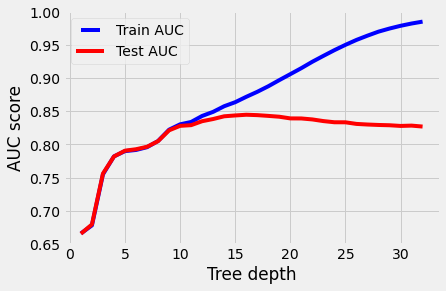

In [13]:
#Indica a profundade da árvore. Quanto maior,mais informação será retida. 
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Acrescenta auc score aos resultados de treino anteriores
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Acrescenta auc score aos resultados de testes anteriores
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [14]:
# Observa-se no gráfico que quanto maior a profundidade, notadamente valores maiores que 12/13, maior o overfitting à base de treino. O modelo prevê perfeitamente todos os labels da base de treino, entretanto, o mesmo não acontece na base de testes. 18 parece uma boa escolha.

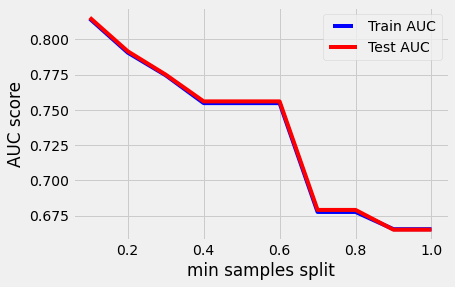

In [15]:
#Ajuste de min_samples_split
# Representa o número mínimo de amostras requerido para dividir um nó.
# Varia de 1 registro em cada nó até todos os registros em cada nó.
# Conforme o número aumenta, mais achatada fica a árvore. 
# No teste abaixo o valor ficará entre 10% e 100%

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()



In [16]:
#Observa-se no gráfico que as curvas na base de teste e de treino estão muito próximas. Assim, ao considerar um numero de amostras bem pequeno para split não resultará em underfitting.

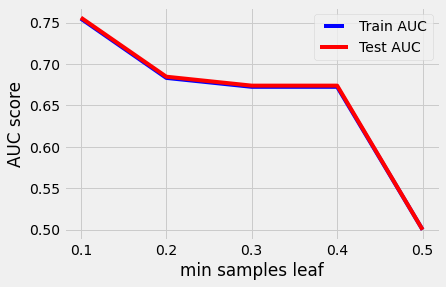

In [17]:
# Ajuste de min_samples_leaf
# Representa o número mínimo de registros requeridos em um nó "folha".
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [18]:
# A conclusão é similar à do parametro anterior. Seu aumento acaba causando underfitting. AUC reduz sem que igualmente na base de treino e de testes. Indica-se utilização de um número pequeno. 

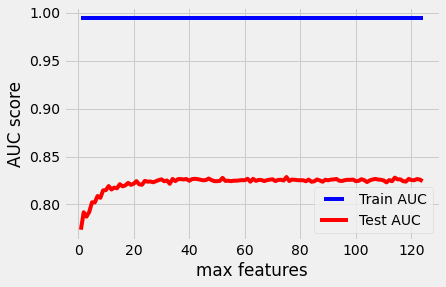

In [39]:
#Ajuste de max_features
#Ajusta o número de "features" a serem consideradas quando decidindo-se por um "split"
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()




In [ ]:
# Observa-se que a partir de 30 features não ocorre incremento significativo no AUC na base de testes. A diferença no indicador nas bases de testes e treino aponta ouverfitting com qualquer número de escolhido. A documentação do sklearn para árvores de decisão informa que a busca por splits não para até que uma partição válida seja encontrada. Ainda que o parâmetro max_features tenha que ser desconsiderado.

In [1]:
# Reavaliação do modelo com os parâmetros ajustados
#     Pycaret
params_DecisionTree = {'ccp_alpha':0.0,
                'class_weight':None,
                'criterion':'gini',
                'max_depth':13,
                'max_features':None,
                'max_leaf_nodes':None,
                'min_impurity_decrease':0.0,
                'min_impurity_split':None,
                'min_samples_leaf':1,
                'min_samples_split':2,
                'min_weight_fraction_leaf':0.0,
                'presort':'deprecated',
                'random_state':3534,
                'splitter':'best'
}
#
#padrao
#(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07, min_samples_leaf=1,
#min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=None, #splitter='best')
# max_depth : 18
# min_samples_split : 1  #biblioteca scikit-learn permite numero absoluto ou percentual
# min_samples_leaf : 2 # biblioteca scikit-learn permite numero absoluto ou percentual


dt2 = DecisionTreeClassifier()
dt2.fit(x_train, y_train)
DecisionTreeClassifier(**params_DecisionTree)
y_pred2 = dt2.predict(x_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [45]:
#Teste de desempenho com os parametros padrao
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8262610030637452